In [ ]:
%tensorflow_version 1.14.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
!pip install seqeval==0.0.5
!pip install keras==2.2.4

  Using cached Keras-2.2.4-py2.py3-none-any.whl (312 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-xa3c3my_
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-xa3c3my_


In [ ]:
from keras.models import *

Using TensorFlow backend.


In [ ]:
from keras_contrib.layers import CRF

In [ ]:
import tensorflow as tf
import keras

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [ ]:

dataset_path = '/content/drive/MyDrive/Medical-Entity-Recognition--master/CADEC.csv'
dataset_path_twitter = '/content/drive/MyDrive/Medical-Entity-Recognition--master/twitter_521.csv'
BATCH_SIZE = 512 # Number of examples used in each iteration
EPOCHS = 400 #Number of passes through entire dataset
MAX_LEN = 60  # Max length of review (in words)
EMBEDDING = 200# Dimension of word embedding vector

In [ ]:
data_twitter = pd.read_csv(dataset_path_twitter, names=['Sentence No', 'Word', 'Tag'], header=0)
data = pd.read_csv(dataset_path)

data = data.drop(['Document ID'], axis=1)
data = data.append(data_twitter[0:5991], ignore_index=True) # Adding some of the twitter data in the cadec dataset to train better for the twitter data

data_twitter = data_twitter[5991:]# Remaining twitter data is for testing
print(data_twitter.shape)
print(data.shape)

data = data.fillna(method="ffill")
data_twitter = data_twitter.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence No'])))
print("Number of sentences in twitter : ", len(data_twitter.groupby(['Sentence No'])))


words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)
words_twitter = list(set(data_twitter["Word"].values))
n_words_twitter = len(words_twitter)
print("Number of words in the dataset: ", n_words_twitter)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("Number of training datasets tags:")
data['Tag'].value_counts()

(6434, 3)
(128571, 3)
Number of sentences:  7771
Number of sentences in twitter :  271
Number of words in the dataset:  9113
Number of words in the dataset:  1971
Tags: ['O', 'B-Symptom', 'I-Finding', 'I-Symptom', 'I-Drug', 'B-ADR', 'I-ADR', 'B-Drug', 'B-Finding', 'I-Disease', 'B-Disease']
Number of Labels:  11
Number of training datasets tags:


O            107139
I-ADR         10900
B-ADR          5756
B-Drug         2058
I-Symptom       482
I-Finding       477
B-Symptom       463
B-Finding       414
B-Disease       353
I-Drug          274
I-Disease       255
Name: Tag, dtype: int64

[[('LabileStudy', 'O'), ('is', 'O'), ('a', 'O'), ('clinical', 'O'), ('trial', 'O'), ('of', 'O'), ('lamotrigine', 'B-Drug'), ('versus', 'O'), ('placebo', 'O'), ('for', 'O'), ('people', 'O'), ('with', 'O'), ('borderline', 'O'), ('personality', 'O'), ('disorder', 'O'), ('.', 'O')], [('#', 'O'), ('QandA', 'O'), ('Yet', 'O'), ('we', 'O'), ('still', 'O'), ('prescribe', 'O'), ('medications', 'O'), ('to', 'O'), ('kids', 'O'), ('like', 'O'), ('Singulair', 'B-Drug'), ('(', 'O'), ('Montelukast', 'B-Drug'), (')', 'O'), ('that', 'O'), ('cause', 'O'), ('neuropsychiatric', 'O'), ('side', 'O'), ('effects', 'O'), ('including', 'O'), ('suicide', 'B-Symptom')], [('#', 'O'), ('QandA', 'O'), ('More', 'O'), ('research', 'O'), ('needs', 'O'), ('to', 'O'), ('be', 'O'), ('done', 'O'), ('in', 'O'), ('regards', 'O'), ('to', 'O'), ('asthma', 'B-Disease'), ('med', 'O'), ('.', 'O'), ('Singulair', 'B-Drug'), ('(', 'O'), ('Montelukast', 'B-Drug'), (')', 'O'), ('which', 'O'), ('causes', 'O'), ('neuropsychiatric', 'O')

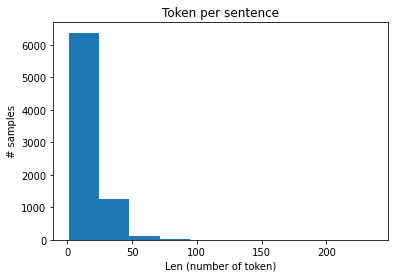

In [ ]:
from random import shuffle
import random
class SentenceGetter(object):
    
    def __init__(self, data):
        
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]                                                 
        self.grouped = self.data.groupby("Sentence No").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
getter_twitter = SentenceGetter(data_twitter)
sent = getter.get_next()# Get all the sentences
sentences = getter.sentences
sentences_twitter = getter_twitter.sentences#tesing all sentences


print(sentences_twitter)
sentences = random.sample(sentences, len(sentences)) # Shuffling the cadec and twitter dataset for better training
print('length of senteces:')
print(len(sentences))
#sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=10)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
#print(word2idx)
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding
word2idx
word2idx_twitter = {w: i + 2 for i, w in enumerate(words_twitter)}
word2idx_twitter["UNK"] = 1 # Unknown words
word2idx_twitter["PAD"] = 0 # Padding
word2idx_twitter




# Vocabulary Key:token_index -> Value:word
idx2word_twitter = {i: w for w, i in word2idx_twitter.items()}#dictionary
idx2word_twitter
idx2word = {i: w for w, i in word2idx.items()}
idx2word

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
tag2idx


# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}
idx2tag


print("The word Drugs is identified by the index: {}".format(word2idx["Drug"]))
print("The labels B-Symptom(which defines Symptom related Enitities) is identified by the index: {}".format(tag2idx["B-Symptom"]))

from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences] #all cadec part

# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"]) #all cadec part

X_twitter = [[word2idx_twitter[w[0]] for w in s] for s in sentences_twitter]

# Padding each sentence to have the same lenght
X_twitter = pad_sequences(maxlen=MAX_LEN, sequences=X_twitter, padding="post", value=word2idx_twitter["PAD"])


# Convert Tag/Label to tag_index
y = [[tag2idx[w[1]] for w in s] for s in sentences]
# Padding each sentence to have the same length
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)


y_twitter = [[tag2idx[w[1]] for w in s] for s in sentences_twitter]
# Padding each sentence to have the same length
y_twitter = pad_sequences(maxlen=MAX_LEN, sequences=y_twitter, padding="post", value=tag2idx["PAD"])
from keras.utils import to_categorical
# One-Hot encode
y_twitter = [to_categorical(i, num_classes=n_tags+1) for i in y_twitter]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split

X_tr, X_te = X, X_twitter #both cadec and tweeter are used for train and test
y_tr, y_te = y, y_twitter #both cadec and tweeter are used for train and test


X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape




The word Drugs is identified by the index: 7716
The labels B-Symptom(which defines Symptom related Enitities) is identified by the index: 2


((7771, 60), (271, 60), (7771, 60, 12), (271, 60, 12))

In [ ]:
print(sentences_twitter)

[[('LabileStudy', 'O'), ('is', 'O'), ('a', 'O'), ('clinical', 'O'), ('trial', 'O'), ('of', 'O'), ('lamotrigine', 'B-Drug'), ('versus', 'O'), ('placebo', 'O'), ('for', 'O'), ('people', 'O'), ('with', 'O'), ('borderline', 'O'), ('personality', 'O'), ('disorder', 'O'), ('.', 'O')], [('#', 'O'), ('QandA', 'O'), ('Yet', 'O'), ('we', 'O'), ('still', 'O'), ('prescribe', 'O'), ('medications', 'O'), ('to', 'O'), ('kids', 'O'), ('like', 'O'), ('Singulair', 'B-Drug'), ('(', 'O'), ('Montelukast', 'B-Drug'), (')', 'O'), ('that', 'O'), ('cause', 'O'), ('neuropsychiatric', 'O'), ('side', 'O'), ('effects', 'O'), ('including', 'O'), ('suicide', 'B-Symptom')], [('#', 'O'), ('QandA', 'O'), ('More', 'O'), ('research', 'O'), ('needs', 'O'), ('to', 'O'), ('be', 'O'), ('done', 'O'), ('in', 'O'), ('regards', 'O'), ('to', 'O'), ('asthma', 'B-Disease'), ('med', 'O'), ('.', 'O'), ('Singulair', 'B-Drug'), ('(', 'O'), ('Montelukast', 'B-Drug'), (')', 'O'), ('which', 'O'), ('causes', 'O'), ('neuropsychiatric', 'O')

In [ ]:
!pip install sklearn-crfsuite

     |████████████████████████████████| 965 kB 5.1 MB/s 


In [ ]:

from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint

# Model definition
input = Input(shape=(MAX_LEN,))
print(input)
input
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, mask_zero=True)(input) 
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLST
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()



Tensor("input_1:0", shape=(?, 60), dtype=float32)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 60, 200)           1823000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 100)           100400    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 60, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 60, 12)            780       
Total params: 1,929,230
Trainable params: 1,929,230
Non-trainable params: 0
_________________________________________________________________





Epoch 1/400





 - 38s - loss: 13.8302 - crf_viterbi_accuracy: 0.6177
Epoch 2/400


/usr/local/lib/python3.7/dist-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


 - 24s - loss: 12.9712 - crf_viterbi_accuracy: 0.8344
Epoch 3/400
 - 19s - loss: 12.8089 - crf_viterbi_accuracy: 0.8439
Epoch 4/400
 - 19s - loss: 12.7105 - crf_viterbi_accuracy: 0.8649
Epoch 5/400
 - 19s - loss: 12.6469 - crf_viterbi_accuracy: 0.8745
Epoch 6/400
 - 20s - loss: 12.6012 - crf_viterbi_accuracy: 0.8872
Epoch 7/400
 - 19s - loss: 12.5669 - crf_viterbi_accuracy: 0.8973
Epoch 8/400
 - 20s - loss: 12.5356 - crf_viterbi_accuracy: 0.9073
Epoch 9/400
 - 19s - loss: 12.5154 - crf_viterbi_accuracy: 0.9130
Epoch 10/400
 - 19s - loss: 12.4954 - crf_viterbi_accuracy: 0.9182
Epoch 11/400
 - 19s - loss: 12.4826 - crf_viterbi_accuracy: 0.9210
Epoch 12/400
 - 19s - loss: 12.4679 - crf_viterbi_accuracy: 0.9243
Epoch 13/400
 - 19s - loss: 12.4566 - crf_viterbi_accuracy: 0.9276
Epoch 14/400
 - 19s - loss: 12.4428 - crf_viterbi_accuracy: 0.9313
Epoch 15/400
 - 19s - loss: 12.4359 - crf_viterbi_accuracy: 0.9319
Epoch 16/400
 - 19s - loss: 12.4258 - crf_viterbi_accuracy: 0.9358
Epoch 17/400
 -

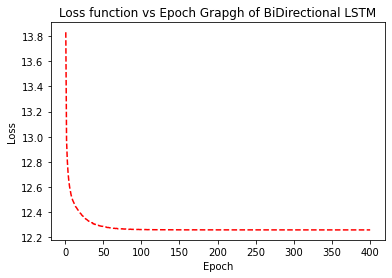

In [ ]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS,validation_split=0.0, callbacks=callbacks_list,verbose=2)
training_loss = history.history['loss']
epoch_count = range(1, len(training_loss) + 1)
# Visualize loss history
plt.title("Loss function vs Epoch Grapgh of BiDirectional LSTM")
plt.plot(epoch_count, training_loss, 'r--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [ ]:
val="flu and osteoarthritis coronary virus is   dangerous for health "

val = [[word2idx[w] for w in val.split()]]
# Padding each sentence to have the same lenght
val = pad_sequences(maxlen=MAX_LEN, sequences=val, padding="post", value=word2idx["PAD"])

print(val)

[[2289 3124 7214 1334 4553 5028 4585 8847 6143    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]


In [ ]:
k = model.predict(val)

In [ ]:
k= np.argmax(k, axis=-1)
k = [[idx2tag[i] for i in row] for row in k]
print(k)

[['B-Disease', 'O', 'B-Disease', 'B-Disease', 'O', 'O', 'O', 'O', 'O', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']]


In [ ]:

# model Evaluation
pred_cat = model.predict(X_te) #X_te
print(pred_cat.shape)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)


(271, 60, 12)


In [ ]:
!pip install sklearn-crfsuite

In [ ]:

# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

In [ ]:
from inspect import TPFLAGS_IS_ABSTRACT
tp = 0
total = 0

for i in range(0,len(pred_tag)):
    for j in range(0,len(pred_tag[0])):      
      if y_te_true_tag[i][j] == pred_tag[i][j]:
        tp += 1
      total += 1
        


In [ ]:
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn import metrics
#import sklearn.metrics
from seqeval.metrics import classification_report


print("===========================")
print(" Accuracy : ",float(((tp)*100)/total),"% ")


 Accuracy :  84.93234932349324 % 


In [ ]:
labels = np.unique(pred_tag+y_te_true_tag)


In [ ]:

# Import label encoder
from sklearn import preprocessing
 
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
 
# Encode labels in column 'species'.
encoded_label= label_encoder.fit(labels)
y_true =[]
y_pred = []
for i in pred_tag:
  y_true.extend(label_encoder.transform(i))

for i in y_te_true_tag:
  y_pred.extend(label_encoder.transform(i))


In [ ]:
len(pred_tag)

271

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_true, y_pred)


array([[   0,   11,   24,    0,    5,    0,    1,    0,    0,    7,  251,
           0],
       [   0,    3,    2,    0,    2,    0,    0,    0,    0,    3,  113,
           0],
       [   0,    3,   13,    0,    3,    0,    0,    0,    0,    4,  122,
           0],
       [   0,    0,    2,    0,    1,    0,    0,    0,    0,    1,   30,
           0],
       [   0,    1,    6,    0,    3,    0,    0,    0,    0,    3,   64,
           0],
       [   0,   10,   35,    0,   37,    0,   10,   19,    0,   28,  684,
           0],
       [   0,    0,    8,    0,    7,    0,    2,    0,    0,    7,  117,
           0],
       [   0,    0,    2,    0,    2,    0,    0,    0,    0,    0,   40,
           0],
       [   0,    0,    3,    0,    0,    0,    0,    0,    0,    1,   32,
           0],
       [   0,    0,    6,    0,    9,    0,    0,    2,    0,    6,  172,
           0],
       [   0,   24,  208,    0,  162,    0,   25,   11,    0,  130, 3957,
           0],
       [   0,    0,  